In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import glob
import dask.dataframe as dd

# import xgboost as xgb
# from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import lightgbm as lgb
import warnings
warnings.simplefilter("ignore")



tar = tarfile.open('../data/raw/20181120_track_features.tar.gz', 'r:gz')
csv_files = tar.getnames()

tf_df_list = []

for csv_file in [csv_files[2], csv_files[4]]:
    csv_contents = tar.extractfile(csv_file).read()
    tf_df_list.append(pd.read_csv(io.BytesIO(csv_contents), encoding='utf8'))

tf_df = pd.concat(tf_df_list, ignore_index=True)
tf_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)

kmean300_df = pd.read_csv('../data/interim/all_data/mbKMeans300clusters.csv', usecols=['track_id','clus'])
kmean300_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)



In [2]:
def get_sim(df_hist, df_lookup, sim_file_list, score_name_list):
    df_hist['ListenYes'] = (df_hist['skip_2'] == False)*1
    df_hist['ListenYes'].replace(0, -1, inplace = True)
    df_hist = df_hist.groupby(['session_id', 'clus']).agg({'ListenYes':['sum']})
    df_hist = df_hist.reset_index()
    df_hist.columns = df_hist.columns.droplevel(level = 1) # take out the unwanted level
    df_pivot = pd.pivot_table(df_hist, values = 'ListenYes',index='session_id', columns='clus')
    df_pivot = df_pivot.fillna(0)
    
    
    for sim_file, score_name in zip(sim_file_list, score_name_list):
        sim_matrix = pd.read_csv(sim_file).drop(columns=['Unnamed: 0'])
        sim_matrix.columns = list(map(str, range(0,len(sim_matrix))))
        df_sim_session = df_pivot.dot(sim_matrix)/sim_matrix.sum()
        
        df_lookup[score_name] = df_sim_session.lookup(df_lookup['session_id'],df_lookup['clus'].astype(str))
    
    return df_lookup

In [3]:
# file_list = glob.glob('../data/raw/training_set/log_9*.csv')
# import random
# random.Random(23).shuffle(file_list) # randomly shuffle the list

In [4]:
# file_list = pd.read_csv('../data/interim/train_valid_split_1217/valid_file_list.csv', header = None)[0].tolist()
# import random
# random.Random(23).shuffle(file_list) # randomly shuffle the list
# file_list

['../data/raw/training_set/log_7_20180903_000000000000.csv',
 '../data/raw/training_set/log_5_20180916_000000000000.csv',
 '../data/raw/training_set/log_6_20180721_000000000000.csv',
 '../data/raw/training_set/log_7_20180831_000000000000.csv',
 '../data/raw/training_set/log_5_20180824_000000000000.csv',
 '../data/raw/training_set/log_8_20180913_000000000000.csv',
 '../data/raw/training_set/log_0_20180913_000000000000.csv',
 '../data/raw/training_set/log_8_20180729_000000000000.csv',
 '../data/raw/training_set/log_3_20180827_000000000000.csv',
 '../data/raw/training_set/log_2_20180716_000000000000.csv',
 '../data/raw/training_set/log_1_20180904_000000000000.csv',
 '../data/raw/training_set/log_9_20180818_000000000000.csv',
 '../data/raw/training_set/log_2_20180912_000000000000.csv',
 '../data/raw/training_set/log_4_20180911_000000000000.csv',
 '../data/raw/training_set/log_3_20180901_000000000000.csv',
 '../data/raw/training_set/log_6_20180803_000000000000.csv',
 '../data/raw/training_s

In [3]:
file_list = ['../data/raw/training_set/log_0_20180918_000000000000.csv']

In [4]:
def prep_dfs_eval(file, tf_df):
    log_df = pd.read_csv(file)
    log_df = log_df.merge(kmean300_df)

    log_df_1 = log_df.loc[log_df['session_position']<=(log_df['session_length']/2)]
    log_df_1['hour_of_day'] = log_df_1['hour_of_day'].astype('float')
    log_df_1['premium'] = log_df_1['premium'].astype('bool')
    log_df_1['weekday'] = log_df_1['date'].astype('datetime64[ns]').dt.dayofweek
    log_df_1 = log_df_1.drop(columns = ['date'])
    log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type','weekday'], dtype = 'bool')
    log_df_1 = log_df_1.merge(tf_df.drop(columns = ['time_signature','mode','key']))
    
                     
    col_bool = log_df_1.columns[log_df_1.dtypes=='bool']
    col_nonbool = log_df_1.columns[log_df_1.dtypes!='bool'].drop(['session_id','track_id_clean','clus'])
    
    # the non-convertable values will be set to 0
    log_df_1[col_nonbool] = log_df_1[col_nonbool].apply(pd.to_numeric, errors='coerce', downcast = 'float').fillna(0).astype('float32')

    # aggregate the track history where ['skip_2']==True
    log_df_1_summary_skip2True = pd.concat([log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_bool].agg(['mean']), 
                                            log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                            axis = 1)
    log_df_1_summary_skip2True.columns = log_df_1_summary_skip2True.columns.get_level_values(0)+'_sk2True_'+log_df_1_summary_skip2True.columns.get_level_values(1)
    
    # aggregate the track history where ['skip_2']==False
    log_df_1_summary_skip2False = pd.concat([log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_bool].agg(['mean']), 
                                             log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                             axis = 1)
    log_df_1_summary_skip2False.columns = log_df_1_summary_skip2False.columns.get_level_values(0)+'_sk2False_'+log_df_1_summary_skip2False.columns.get_level_values(1)
    
    
    log_df_history = log_df_1[['session_id','track_id_clean','skip_2','clus']]


    half_cut = log_df['session_length']/2

    # need to at least include 2 trials, otherwise the log_df_1_summary will confound with all the tracks in the same session

#     #1st trial in the 2nd half
#     log_df_2_1 = log_df.loc[(log_df['session_position']>half_cut) & (log_df['session_position']<=half_cut+1)]
#     log_df_2_1 = log_df_2_1[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
#     log_df_2_1['weight'] = 1

#     #2nd trial in the 2nd half
#     log_df_2_2 = log_df.loc[(log_df['session_position']>half_cut+1) & (log_df['session_position']<=half_cut+2)]
#     log_df_2_2 = log_df_2_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
#     log_df_2_2['weight'] = 0.75

#     log_df_2 = pd.concat([log_df_2_1,log_df_2_2])

    log_df_2 = log_df.loc[(log_df['session_position']>half_cut)]
    log_df_2 = log_df_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2True, on='session_id')
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2False, on='session_id')

    sim_file_list = ['../models/SVD/all_tracks/similarity_for20180918/k300_CanbDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_CosSim.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_LinCorr.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_ManhDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_HammDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_SpearCorr.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_KendCorr.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_ChebDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_BrayDist.csv']
    score_name_list = ['CanbDist300', 'CosSim300','LinCorr300','ManhDist300','HammDist300','SpearCorr300','KendCorr300','ChebDist','BrayDist']

    return get_sim(log_df_history, log_df_2, sim_file_list, score_name_list)

In [5]:
from timeit import default_timer as timer #to see how long the computation will take

df_lookup_list = []
for file in file_list[0:1]:
    start = timer()
    df_lookup_list.append(prep_dfs_eval(file, tf_df))
    
df_lookup = pd.concat(df_lookup_list)
df_lookup = df_lookup.merge(tf_df.drop(columns = ['key','time_signature','mode']))

# check whether the column names match with the previous training set
prev_feature_names = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/LightGBM_incremental_training_dec19/boost_20180918.txt').feature_name()
if bool(set(prev_feature_names) - set(df_lookup.columns)): # if there are missing columns
    df_lookup[list(set(prev_feature_names) - set(df_lookup.columns))] = 0 # add the missed columns with 0

df_lookup.sort_values(['session_id','session_position'], inplace = True)
X = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).to_numpy()

# bst = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/LightGBM_incremental_training_dec19/boost10.txt')  # init model
bst = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/LightGBM_incremental_training_dec19/boost_20180918.txt')  # init model

ypred = bst.predict(X)
print('Runtime per batch: %0.2fs' % (timer() - start))

Runtime per batch: 74.37s


In [7]:
# from timeit import default_timer as timer #to see how long the computation will take


# for file in file_list[0:1]:
#     start = timer()
#     log_df = pd.read_csv(file)
#     log_df = log_df.merge(kmean300_df)

#     log_df_1 = log_df.loc[log_df['session_position']<(log_df['session_length']/2)]
#     log_df_1['hour_of_day'] = log_df_1['hour_of_day'].astype('float')
#     log_df_1['premium'] = log_df_1['premium'].astype('bool')
#     log_df_1['weekday'] = log_df_1['date'].astype('datetime64[ns]').dt.dayofweek
#     log_df_1 = log_df_1.drop(columns = ['date'])
#     log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type'])
#     log_df_1_summary = log_df_1.groupby(['session_id'])[col_FA].agg(['mean'])
#     log_df_1_summary.columns = log_df_1_summary.columns.get_level_values(0)+'_'+log_df_1_summary.columns.get_level_values(1)
#     log_df_history = log_df_1[['session_id','track_id_clean','skip_2','clus']]


#     half_cut = log_df['session_length']/2
#     log_df_2 = log_df.loc[log_df['session_position']>half_cut]
#     log_df_2 = log_df_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
#     log_df_2['weight'] = 1/(log_df['session_position']-half_cut)
#     log_df_2 = log_df_2.merge(log_df_1_summary, on='session_id')


#     sim_file_list = ['../models/SVD/similarity/k300_CanbDist.csv',
#                      '../models/SVD/similarity/k300_CosSim.csv',
#                      '../models/SVD/similarity/k300_LinCorr.csv',
#                      '../models/SVD/similarity/k300_ManhDist.csv',
#                      '../models/SVD/similarity/k300_HammDist.csv',
#                      '../models/SVD/similarity/k300_SpearCorr.csv',
#                      '../models/SVD/similarity/k300_KendCorr.csv']
#     score_name_list = ['CanbDist300', 'CosSim300','LinCorr300','ManhDist300','HammDist300','SpearCorr300','KendCorr300']

#     df_lookup = get_sim(log_df_history, log_df_2, sim_file_list, score_name_list)
#     df_lookup = df_lookup.merge(tf_df)
#     df_lookup.drop(columns = ['key','time_signature','mode'], inplace = True)
#     df_lookup.sort_values(['session_id','session_position'], inplace = True)
#     X = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).to_numpy()
    
#     bst = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt/LightGBM_incremental_training/boost410.txt')  # init model

#     ypred = bst.predict(X)
#     print('Runtime per batch: %0.2fs' % (timer() - start))





In [6]:
df_lookup

,session_id,track_id_clean,skip_2,session_position,session_length,clus,skip_1_sk2True_mean,skip_2_sk2True_mean,skip_3_sk2True_mean,not_skipped_sk2True_mean,...,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,hist_user_behavior_reason_start_clickside_sk2False_mean,hist_user_behavior_reason_start_clickside_sk2True_mean
490688,65_00010f79-6cdf-4dbb-b397-f7bee25e59c4,t_ddb52bc1-32d7-487b-a28a-9c163b0d738c,True,10,18,167,1.000,1.0,1.0,0.0,...,-0.370279,0.568018,0.102051,-0.371437,-0.096813,0.142948,-0.313205,0.197133,0,0
490700,65_00010f79-6cdf-4dbb-b397-f7bee25e59c4,t_b4b99990-0ff7-49e1-8f30-41bbbee49767,True,11,18,110,1.000,1.0,1.0,0.0,...,-0.867898,0.268336,0.228385,0.193234,-0.268218,-0.019627,-0.402115,0.115647,0,0
490765,65_00010f79-6cdf-4dbb-b397-f7bee25e59c4,t_9d99d01a-52b9-47d7-9e6b-84e9c6d1671e,True,12,18,75,1.000,1.0,1.0,0.0,...,-0.839231,0.327025,0.270949,0.119399,-0.454775,0.005303,-0.226446,0.338173,0,0
490780,65_00010f79-6cdf-4dbb-b397-f7bee25e59c4,t_aaea4c20-e5f4-4ade-9543-5a1c5ff9a75c,True,13,18,113,1.000,1.0,1.0,0.0,...,-0.309166,0.049526,0.291276,0.013656,-0.222894,0.039514,-0.261746,-0.137086,0,0
490849,65_00010f79-6cdf-4dbb-b397-f7bee25e59c4,t_cd5723ea-e45d-4ff0-b055-5a20ce59a36e,True,14,18,10,1.000,1.0,1.0,0.0,...,-0.783345,0.316083,0.179289,0.099781,-0.302417,-0.073292,-0.348184,0.147441,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982308,65_fffff44f-3a16-45fe-9467-a93e66c29444,t_a52b4c4c-cad9-446a-b02f-69917e6cff9c,False,16,20,78,0.875,1.0,1.0,0.0,...,-0.822615,0.418104,0.279235,-0.018779,-0.267292,0.045970,-0.504089,0.145203,0,0
372075,65_fffff44f-3a16-45fe-9467-a93e66c29444,t_e48d2f95-ecab-498a-a418-f76f022097e0,False,17,20,77,0.875,1.0,1.0,0.0,...,-0.809946,0.301279,0.328006,0.033760,-0.303923,0.030537,-0.579936,0.111257,0,0
244541,65_fffff44f-3a16-45fe-9467-a93e66c29444,t_fd1275ed-bf07-4879-8a6b-722e24ec1de0,False,18,20,89,0.875,1.0,1.0,0.0,...,-0.787478,0.227547,0.229743,0.117927,-0.326255,-0.027055,-0.581198,0.153939,0,0
140463,65_fffff44f-3a16-45fe-9467-a93e66c29444,t_6764729f-effc-48e7-9328-9f71fe85e0e9,False,19,20,75,0.875,1.0,1.0,0.0,...,-0.685107,0.246976,0.165717,0.016374,-0.280892,-0.002110,-0.416867,0.198200,0,0


In [7]:
ytrue = df_lookup['skip_2']
ytrue

490688     True
490700     True
490765     True
490780     True
490849     True
          ...  
982308    False
372075    False
244541    False
140463    False
983840     True
Name: skip_2, Length: 1360243, dtype: bool

In [8]:
ypred

array([0.86580587, 0.93491811, 0.92811831, ..., 0.89150351, 0.84892258,
       0.75773021])

In [9]:
from sklearn.metrics import accuracy_score
acc = []
for x in np.arange(0,1,0.01):
    acc.append(accuracy_score(ypred>x, ytrue*1))


In [10]:
max(acc)

0.6092727549415803

In [11]:
max_index = acc.index(max(acc))
max_index

62

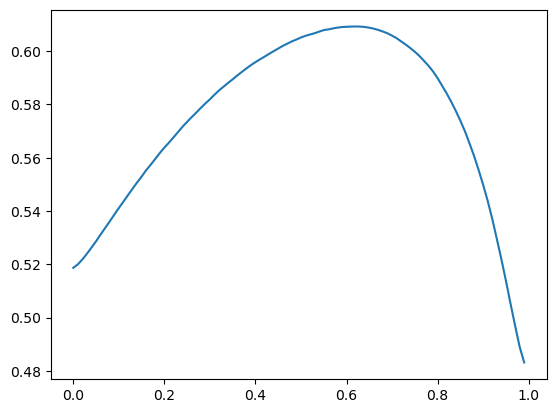

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,1,0.01), acc)
plt.show()

In [13]:
## evaludation functions

def get_ground_truth(test_output):

    ground_truths = [] 
    df = test_output
    df[['session_position','session_length']] = df[['session_position','session_length']].astype('int64')
    df = df[['session_id','skip_2','session_position','session_length']].loc[df['session_position']*2 > df['session_length']]
    df = df.reset_index()
    current_index = 0
    while current_index < len(df):
        partial_length = df['session_length'].iloc[current_index]-df['session_position'].iloc[current_index]+1
        session_skips = list(df.loc[current_index:current_index+partial_length-1, 'skip_2'])
        ground_truths.append(session_skips)
        current_index += partial_length 
    return ground_truths


def get_submission(test_output):
    submission = []
    for s in test_output['session_id'].unique():
        submission.append(np.array(test_output['pred'][test_output['session_id']==s]*1))
    return submission


def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc


def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

def spotify_eval(y_true, y_pred, input_df):
    df_temp = input_df.loc[y_true.index.values,['session_id','skip_2','session_position','session_length']]
    df_temp['pred'] = y_pred
    ground_truths = get_ground_truth(df_temp)
    submission = get_submission(df_temp)
#     return ground_truths, submission
    ap,first_pred_acc = evaluate(submission,ground_truths)
    return ap,first_pred_acc

In [16]:
s_list = df_lookup['session_id'].unique()[0:2000]
sel_row = df_lookup['session_id'].isin(s_list)

In [19]:
ap,first_pred_acc  = spotify_eval(ytrue[sel_row], ypred[sel_row]>0.62, df_lookup.sort_values(['session_id','session_position']).loc[sel_row])

In [24]:
# ap,first_pred_acc  = spotify_eval(ytrue, ypred>0.01, df_lookup.sort_values(['session_id','session_position']))

KeyboardInterrupt: 

In [20]:
ap

0.5079842243008313

In [21]:
first_pred_acc

0.682

In [20]:
df_lookup.sort_values(['session_id','session_position'])

,session_id,track_id_clean,skip_2,session_position,session_length,clus,skip_1_sk2True_mean,skip_2_sk2True_mean,skip_3_sk2True_mean,not_skipped_sk2True_mean,...,hist_user_behavior_reason_start_clickside_sk2True_mean,hist_user_behavior_reason_start_uriopen_sk2False_mean,hist_user_behavior_reason_end_popup_sk2False_mean,hist_user_behavior_reason_start_uriopen_sk2True_mean,hist_user_behavior_reason_start_popup_sk2True_mean,hist_user_behavior_reason_start_popup_sk2False_mean,hist_user_behavior_reason_end_popup_sk2True_mean,hist_user_behavior_reason_end_uriopen_sk2False_mean,hist_user_behavior_reason_end_clickside_sk2True_mean,hist_user_behavior_reason_start_clickside_sk2False_mean
7581,50_0000a26a-7fde-4047-a002-f3074ffd93d9,t_bc857678-889b-475c-91d7-4d024367baa0,True,11,20,78,0.833333,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7939,50_0000a26a-7fde-4047-a002-f3074ffd93d9,t_ca817013-ad2d-440b-b643-bb30cf16601b,True,12,20,64,0.833333,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
544,50_0000a26a-7fde-4047-a002-f3074ffd93d9,t_15d84f1f-1d59-4426-bfb0-40b853a53229,False,13,20,295,0.833333,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7986,50_0000a26a-7fde-4047-a002-f3074ffd93d9,t_1bb7f9ad-86f1-4eeb-a18c-18423f7d1be9,False,14,20,125,0.833333,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
10459,50_0000a26a-7fde-4047-a002-f3074ffd93d9,t_557fe7ca-506c-4908-ab00-e6be20ccfeff,False,15,20,32,0.833333,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419558,50_fffffa3f-a196-4996-8503-f7b698e8f760,t_f192b360-5fc9-46be-942a-d32f757d55dc,False,16,20,114,1.000000,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
164653,50_fffffa3f-a196-4996-8503-f7b698e8f760,t_06ae3ffb-b082-489b-8dd2-23e0d69f9824,True,17,20,281,1.000000,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
682380,50_fffffa3f-a196-4996-8503-f7b698e8f760,t_dc7f2d2b-eca8-48af-a2b0-4e4527136882,False,18,20,237,1.000000,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
303339,50_fffffa3f-a196-4996-8503-f7b698e8f760,t_1f6009ef-3bfa-4b6c-b3e8-9763e3a08815,False,19,20,180,1.000000,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
len(df_lookup['skip_2'][sel_row])

17096